In [1]:
# import data
from pylab import *
from sklearn.utils import shuffle
# from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
import sys
import pickle

sys.path.insert(0, '../src')

%matplotlib inline
import h5py

In [2]:
from numpy import *
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)

rn.seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# tf.set_random_seed(12345)
tf.random.set_seed(12345)

sees = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sees)
tf.compat.v1.keras.backend.set_session(sees)

Using TensorFlow backend.


In [3]:
# cnn model
import keras
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv1D, ZeroPadding1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers.core import Reshape 
from keras import activations

In [4]:
def build_model(trainX, trainy):
    keras.backend.clear_session()
    
    n_offset = trainX.shape[1]
    n_outputs = trainy.shape[1]
    print (n_outputs)
    n_features = 1
    
    model = Sequential()
#     model.add(Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
    
#     1st
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv_1', input_shape=(n_offset,n_features)))
    model.add(MaxPooling1D(pool_size=2))  
#     model.add(Dropout(0.25))
              
#     2nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_2'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     3nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_3'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     4th
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_4'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
              
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', name='dense'))
    
    model.add(Dense(n_outputs, activation='softmax', name='output'))   
    sgd = keras.optimizers.SGD(lr=0.01)
    model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = sgd)
    
#     model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = keras.optimizers.sgd())
           
    model.summary()
    return model

In [5]:
import pickle

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    mse = smooth_curve(history.history['accuracy'][:steps])
    val_mse = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(mse, c='#0c7cba', label='Train accuracy')
    plt.plot(val_mse, c='#0f9d58', label='Val accuracy')
    plt.xticks(range(0, len(mse), 5))
    plt.xlim(0, len(mse))
    plt.title('Train accuracy: %.3f, Val accuracy: %.3f' % (mse[-1], val_mse[-1]), fontsize=12)
    plt.legend()

In [6]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

In [7]:
def evaluate_model(X, y):
    verbose, epochs, batch_size = 1, 200, 64
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     patience: Number of epochs with no improvement after which training will be stopped.
    model = build_model(X, y)
    history = model.fit(X, y, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, verbose=verbose,
                       callbacks=[early_stop]) 

    model.save_weights('model_weights_20210201_64_4_test.h5')
        
    save_history(history, 'history_20210201_64_4_test.bin')
#     history = load_history('history.bin')
#     plot_compare(history, steps=50)  
    return model

In [8]:
# summarize scores
def summarize_results(scores):
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
        # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# load training data

In [9]:
cestFreq = np.linspace(-6,6,81)
filepath = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20210104/simulation_matlab/'

file=h5py.File(filepath + 'training_simData_2.0uT_20210201.h5','r')
simulationMatrix2pt = file['simData'][:]
simulationMatrix2pt = simulationMatrix2pt
trainingDataIndex2pt = file['Index'][:]
trainingDataIndex2pt.shape

file=h5py.File(filepath + 'training_simData_1.0uT_20210201.h5','r')
simulationMatrix1pt = file['simData'][:]
simulationMatrix1pt = simulationMatrix1pt
trainingDataIndex1pt = file['Index'][:]
trainingDataIndex1pt.shape

file=h5py.File(filepath + 'training_simData_0.5uT_20210201.h5','r')
simulationMatrix0pt5 = file['simData'][:]
simulationMatrix0pt5 = simulationMatrix0pt5
trainingDataIndex0pt5 = file['Index'][:]
trainingDataIndex0pt5.shape

(300000,)

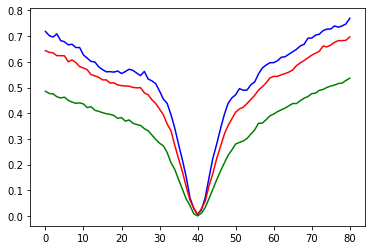

In [10]:
plot(simulationMatrix2pt[20],'b')
plot(simulationMatrix2pt[100000],'r')
plot(simulationMatrix2pt[200000],'g')

# model0 MCF-7 & MDA-231 & normal PCA

In [11]:
trainingDataIndex0 = trainingDataIndex2pt

In [12]:
freq_Zspec0 = np.where( (cestFreq >=-6.1) * (cestFreq <= 6.1))

trainingMatrix0 = []
for ii in range(simulationMatrix2pt.shape[0]):
    trainingFeatures = []
    trainingFeatures += list(squeeze(simulationMatrix2pt[ii,freq_Zspec0]))
#     trainingFeatures += list(squeeze(simulationMatrix1pt[ii,freq_Zspec0]))
#     trainingFeatures += list(squeeze(simulationMatrix0pt5[ii,freq_Zspec0]))
    trainingMatrix0.append(trainingFeatures)
trainingDataNew0 = array(trainingMatrix0)

In [13]:
trainingDataIndex0 = keras.utils.to_categorical(trainingDataIndex2pt, 3)


In [14]:
trainX0 = trainingDataNew0
trainX0 = reshape(trainX0,(trainX0.shape[0], trainX0.shape[1], 1))
trainy0 = trainingDataIndex0

In [15]:
   # test data
testX, testy = shuffle(trainX0, trainy0, random_state=42)

In [16]:
# # CNN training
# import time

# start_time = time.clock()
# trainXnew = testX
# trainynew = testy
# model = evaluate_model(trainXnew, trainynew)

# print (time.clock() - start_time, "seconds")

3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 81, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 20, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 10, 64)        

In [16]:
trainXnew = testX
trainynew = testy
model = build_model(trainXnew, trainynew)
model.load_weights("model_weights_20210201_64_4_test.h5")

3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 81, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 20, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 10, 64)         

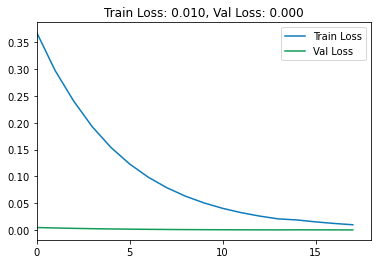

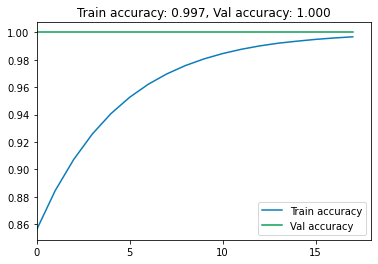

In [17]:
history = load_history('history_20210201_64_4_test.bin')
plot_compare(history, steps=50)

In [18]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
def my_custom_loss_func(y_true, y_pred):
    
    y_true_new = zeros(y_true.shape[0])
    y_pred_new = zeros(y_pred.shape[0])

    for ii in range(y_true.shape[0]):
        y_true_new[ii] = numpy.argmax(y_true[ii])
        y_pred_new[ii] = numpy.argmax(y_pred[ii])
    
    score = 0
    for ii in range(y_true.shape[0]):
        if y_pred_new[ii] == y_true_new[ii]:
            score=score+1
    score = score / y_true.shape[0]
    return score

In [20]:
# read data
import numpy

mouse = 'M3_2'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M3-2/'
sep_2pt = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M3_2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

# mouse = 'M1_3'
# path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M1-3/'
# sep_2pt = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

# mouse = 'M2'
# path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M2/'
# sep_2pt = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

# mouse = 'M3'
# path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M3/'
# sep_2pt = np.loadtxt(path2 + 'M3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')


# mouse = 'M1'
# path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
# sep_2pt = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

# mouse = 'M4'
# path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M4/'
# sep_2pt = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# Index = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

cestFreq = np.linspace(-6,6,81)

# reshape test_invivo
expDataMatrix0_2pt_use = sep_2pt

combinedExpData0 = []
for ii in range(expDataMatrix0_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix0_2pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_1pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_0pt5_use[ii,freq_Zspec0]))
    combinedExpData0.append(combinedExpDatai)
combinedExpData0 = array(combinedExpData0)
test_invivo = combinedExpData0

test_invivo = reshape(test_invivo, (test_invivo.shape[0], test_invivo.shape[1],1))
test_Label = keras.utils.to_categorical(Index, 3)

all_preds = model.predict(test_invivo) 
Invivo_pred_new = zeros(all_preds.shape[0])

for ii in range(all_preds.shape[0]):
    Invivo_pred_new[ii] = numpy.argmax(all_preds[ii])

from sklearn import metrics
from sklearn.metrics import f1_score
print('mean_squraed_error: %f' % (metrics.mean_squared_error(Invivo_pred_new, Index)))
print('accuracy_score: %.3f' % (metrics.accuracy_score(Invivo_pred_new, Index, normalize=True, sample_weight=None)))
print('accuracy_score: %.3f' % (my_custom_loss_func(all_preds, test_Label)))


# average_precision_score

mean_squraed_error: 0.367241
accuracy_score: 0.757
accuracy_score: 0.757


In [21]:
# =============================================
# Saliency Maps code
# =============================================
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

layer_index = utils.find_layer_idx(model, 'output')
model.layers[layer_index].activation = activations.linear
model_new = utils.apply_modifications(model)  


help(utils.apply_modifications)# =============================================
# Saliency Maps code
# =============================================
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

layer_index = utils.find_layer_idx(model, 'output')
model.layers[layer_index].activation = activations.linear
model_new = utils.apply_modifications(model)  


help(utils.apply_modifications)

Help on function apply_modifications in module vis.utils.utils:

apply_modifications(model, custom_objects=None)
    Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.
    
    Args:
        model: The `keras.models.Model` instance.
    
    Returns:
        The modified model with changes applied. Does not mutate the original `model`.

Help on function apply_modifications in module vis.utils.utils:

apply_modifications(model, custom_objects=None)
    Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building

In [120]:
# inds_0=where((Index==0))[0][36:40]
# inds_1=where((Index==1))[0][9:13]
# inds_2=where((Index==2))[0][70:74]


inds_0=(where((Index==0)) and where((Invivo_pred_new==0)))[0][30:50]
inds_1=(where((Index==1)) and where((Invivo_pred_new==1)))[0][30:50]
inds_2=(where((Index==2)) and where((Invivo_pred_new==2)))[0][30:50]
        

In [124]:
Invivo_pred_new[inds_1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [125]:
from vis.visualization import visualize_saliency
# class_idx = r_[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2]
test = zeros((60,test_invivo.shape[1],test_invivo.shape[2]))
test[:20] = test_invivo[inds_0]
test[20:40] = test_invivo[inds_1]
test[40:] = test_invivo[inds_2]
grad_top = zeros((test.shape[0],test.shape[1]))

for ii in range(test.shape[0]):
    print (ii)
    if ii <20:
        class_idx = 0
    elif ii>=20 and ii <40:
        class_idx = 1
    elif ii>=40:
        class_idx = 2
        
    test_use = test[ii]
    input_image = test_use[np.newaxis,...]
    grad_top[ii] = visualize_saliency(model_new,
                               layer_index,
                               filter_indices = class_idx,
                               seed_input     = input_image)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


Text(-0.5, 0.5, 'True label')

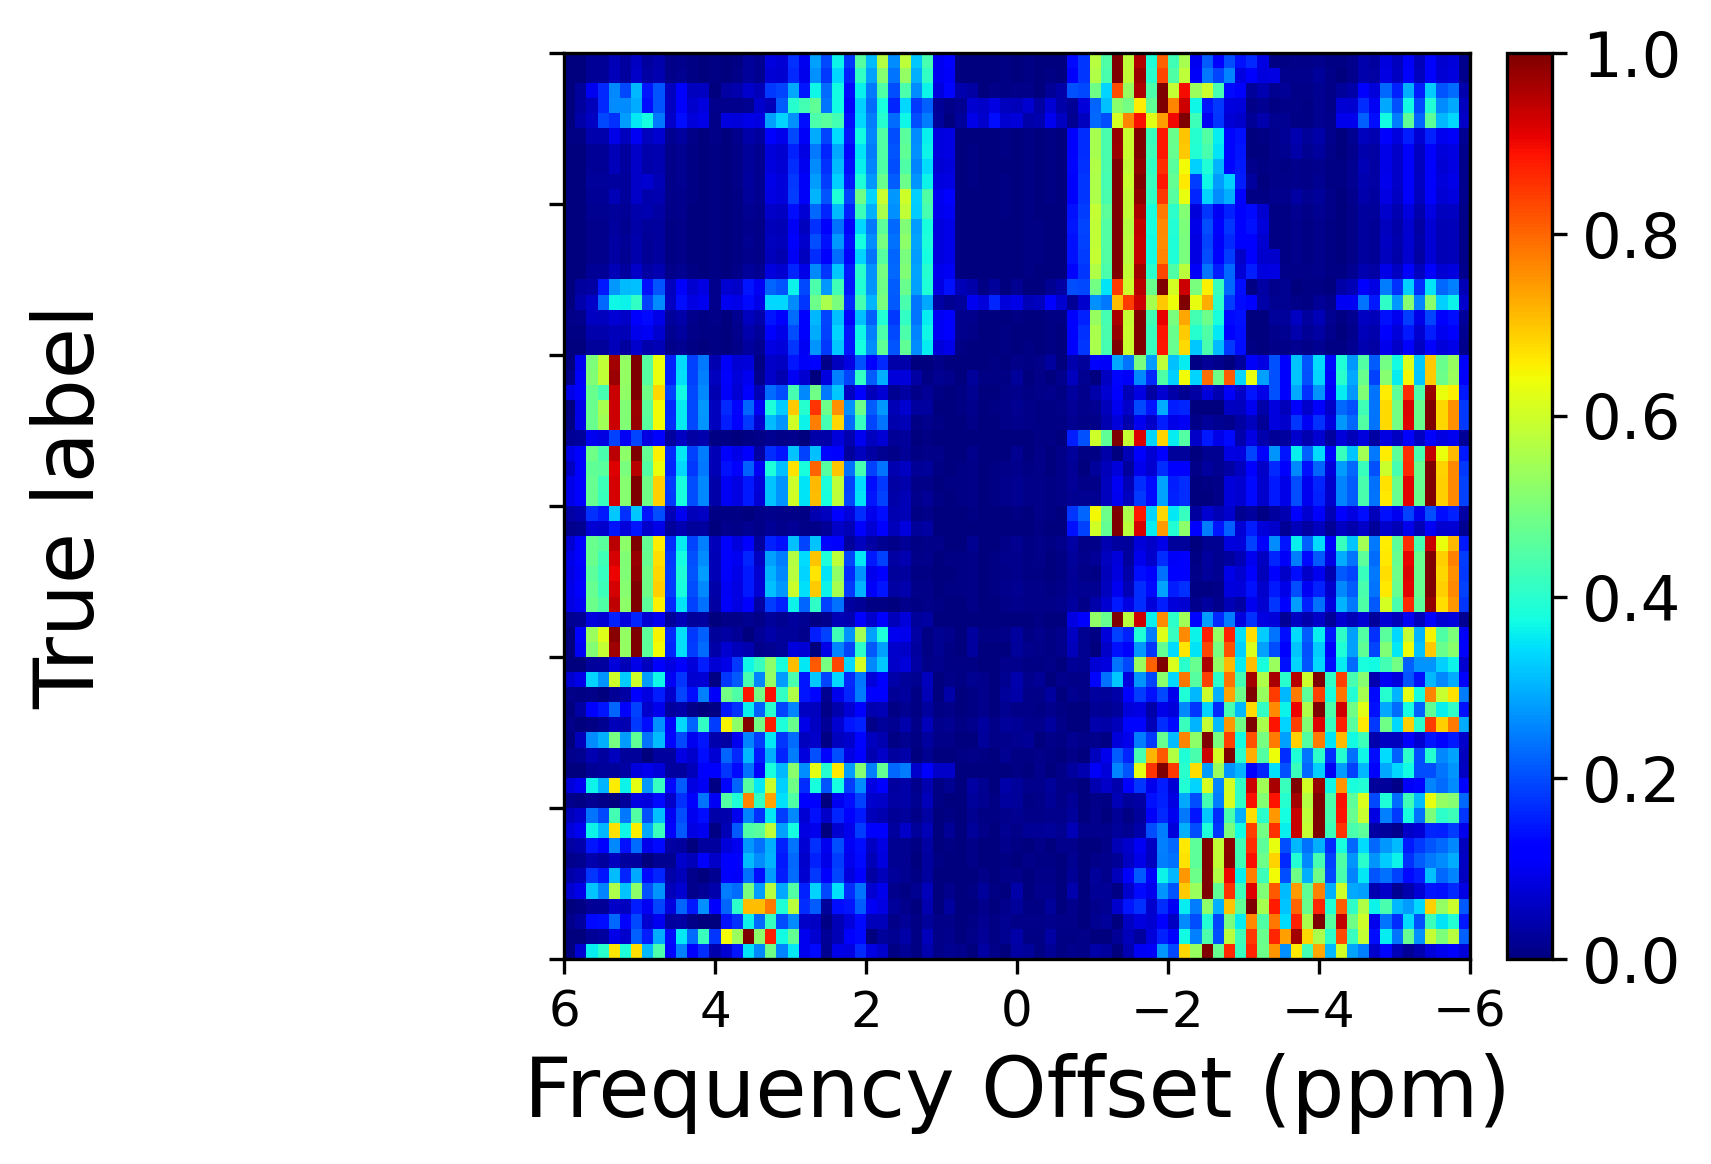

In [126]:
fig, ax = plt.subplots(1,1,figsize = (8,4),dpi=300)
# title('Saliency map', fontsize=25)
grad_top_filp = zeros(grad_top.shape)
grad_top_filp = fliplr(grad_top)

img = ax.imshow(grad_top_filp,extent=[6,-6,0,12], cmap='jet')
img.set_clim(0, 1)

# y_label_list = ["","Muscle","","MCF-7","","MDA-MB-231",]
y_label_list = ["","","","","","",]
x_label_list = flipud(cestFreq)
ax.set_yticklabels(y_label_list,fontsize=15)
# plt.setp(ax.get_yticklabels(), rotation=60, ha="right",
#          rotation_mode="anchor")
plt.rcParams['xtick.labelsize']=12

# fig.colorbar(img)
cbar = fig.colorbar(img,  pad=0.02,shrink=1,ticks = [0,0.2,0.4,0.6,0.8,1.0])

# ax.set_xticklabels([6, 4, 2, 0, -2, -4, -6])
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('Frequency Offset (ppm)', fontsize=20)
# ax.set_ylabel('True label', fontsize=20)
ax.text(-0.5, 0.5, 'True label', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax.transAxes, fontsize=20)

# test on simulation data

In [20]:
import scipy.io
filepath_noise = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/simulation_matlab/'
file=h5py.File(filepath_noise + 'training_simData_noise_2.0uT_20210201.h5','r')
test_sim_data_noise_use = file['simData'][:]
test_sim_data_noise_use = test_sim_data_noise_use
test_sim_index = file['Index'][:]
test_sim_index.shape

sdNoise = r_[0.005, 0.008, 0.01, 0.012, 0.015, 0.017, 0.02, 0.025, 0.03]
# [0.001, 0.003, 0.005, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03]

(6.0, -6.0)

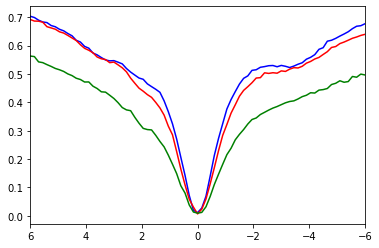

In [21]:
plot(cestFreq,test_sim_data_noise_use[20,:,0],'b')
plot(cestFreq,test_sim_data_noise_use[1000,:,0],'r')
plot(cestFreq,test_sim_data_noise_use[2000,:,0],'g')

xlim(6, -6)

In [22]:
import numpy
from sklearn import metrics

for ij in range(len(sdNoise)):
    print('sdNoise: %f' % sdNoise[ij])
    
    data_use = test_sim_data_noise_use[:,:,ij]
    index_use = test_sim_index
   
    #model 0
    combinedExpData0 = []
    for ii in range(data_use.shape[0]):
        combinedExpDatai = []
        combinedExpDatai+=list(data_use[ii,freq_Zspec0])
        combinedExpData0.append(combinedExpDatai)
    combinedExpData0 = array(combinedExpData0)

    testInvivo0 = squeeze(combinedExpData0)
    testInvivo0 = reshape(testInvivo0, (testInvivo0.shape[0], testInvivo0.shape[1],1))
 
    
# model 2
    combinedExpData2 = []
    for ii in range(data_use.shape[0]):
        combinedExpDatai = []
        combinedExpDatai+=list(squeeze(data_use[ii,freq_Zspec2]))
        combinedExpData2.append(combinedExpDatai)
    combinedExpData2 = array(combinedExpData2)

    testInvivo2 = combinedExpData2
  
    #predict
#     Invivo_pred0 = clf0.predict(testInvivo0)

    Invivo_pred0 = model.predict(testInvivo0)

    Invivo_pred01 = zeros(Invivo_pred0.shape[0])

    for ii in range(Invivo_pred0.shape[0]):
        Invivo_pred01[ii] = numpy.argmax(Invivo_pred0[ii])
    
    print('accuracy_score_1st: %.3f' % (metrics.accuracy_score(index_use, Invivo_pred01)))


sdNoise: 0.005000
accuracy_score_1st: 1.000
sdNoise: 0.008000
accuracy_score_1st: 1.000
sdNoise: 0.010000
accuracy_score_1st: 1.000
sdNoise: 0.012000
accuracy_score_1st: 1.000
sdNoise: 0.015000
accuracy_score_1st: 1.000
sdNoise: 0.017000
accuracy_score_1st: 0.995
sdNoise: 0.020000
accuracy_score_1st: 0.921
sdNoise: 0.025000
accuracy_score_1st: 0.715
sdNoise: 0.030000
accuracy_score_1st: 0.670


In [23]:
n_classes = 3
trainingDataLabels = ['MDA-MB-231','MCF-7', 'muscle']
# 1st
Accuracy1 = r_[1.000, 1.000, 1.000, 1.000, 1.000, 0.995, 0.921, 0.715, 0.670]*100


0
1
2
3
4
5
6
7
8


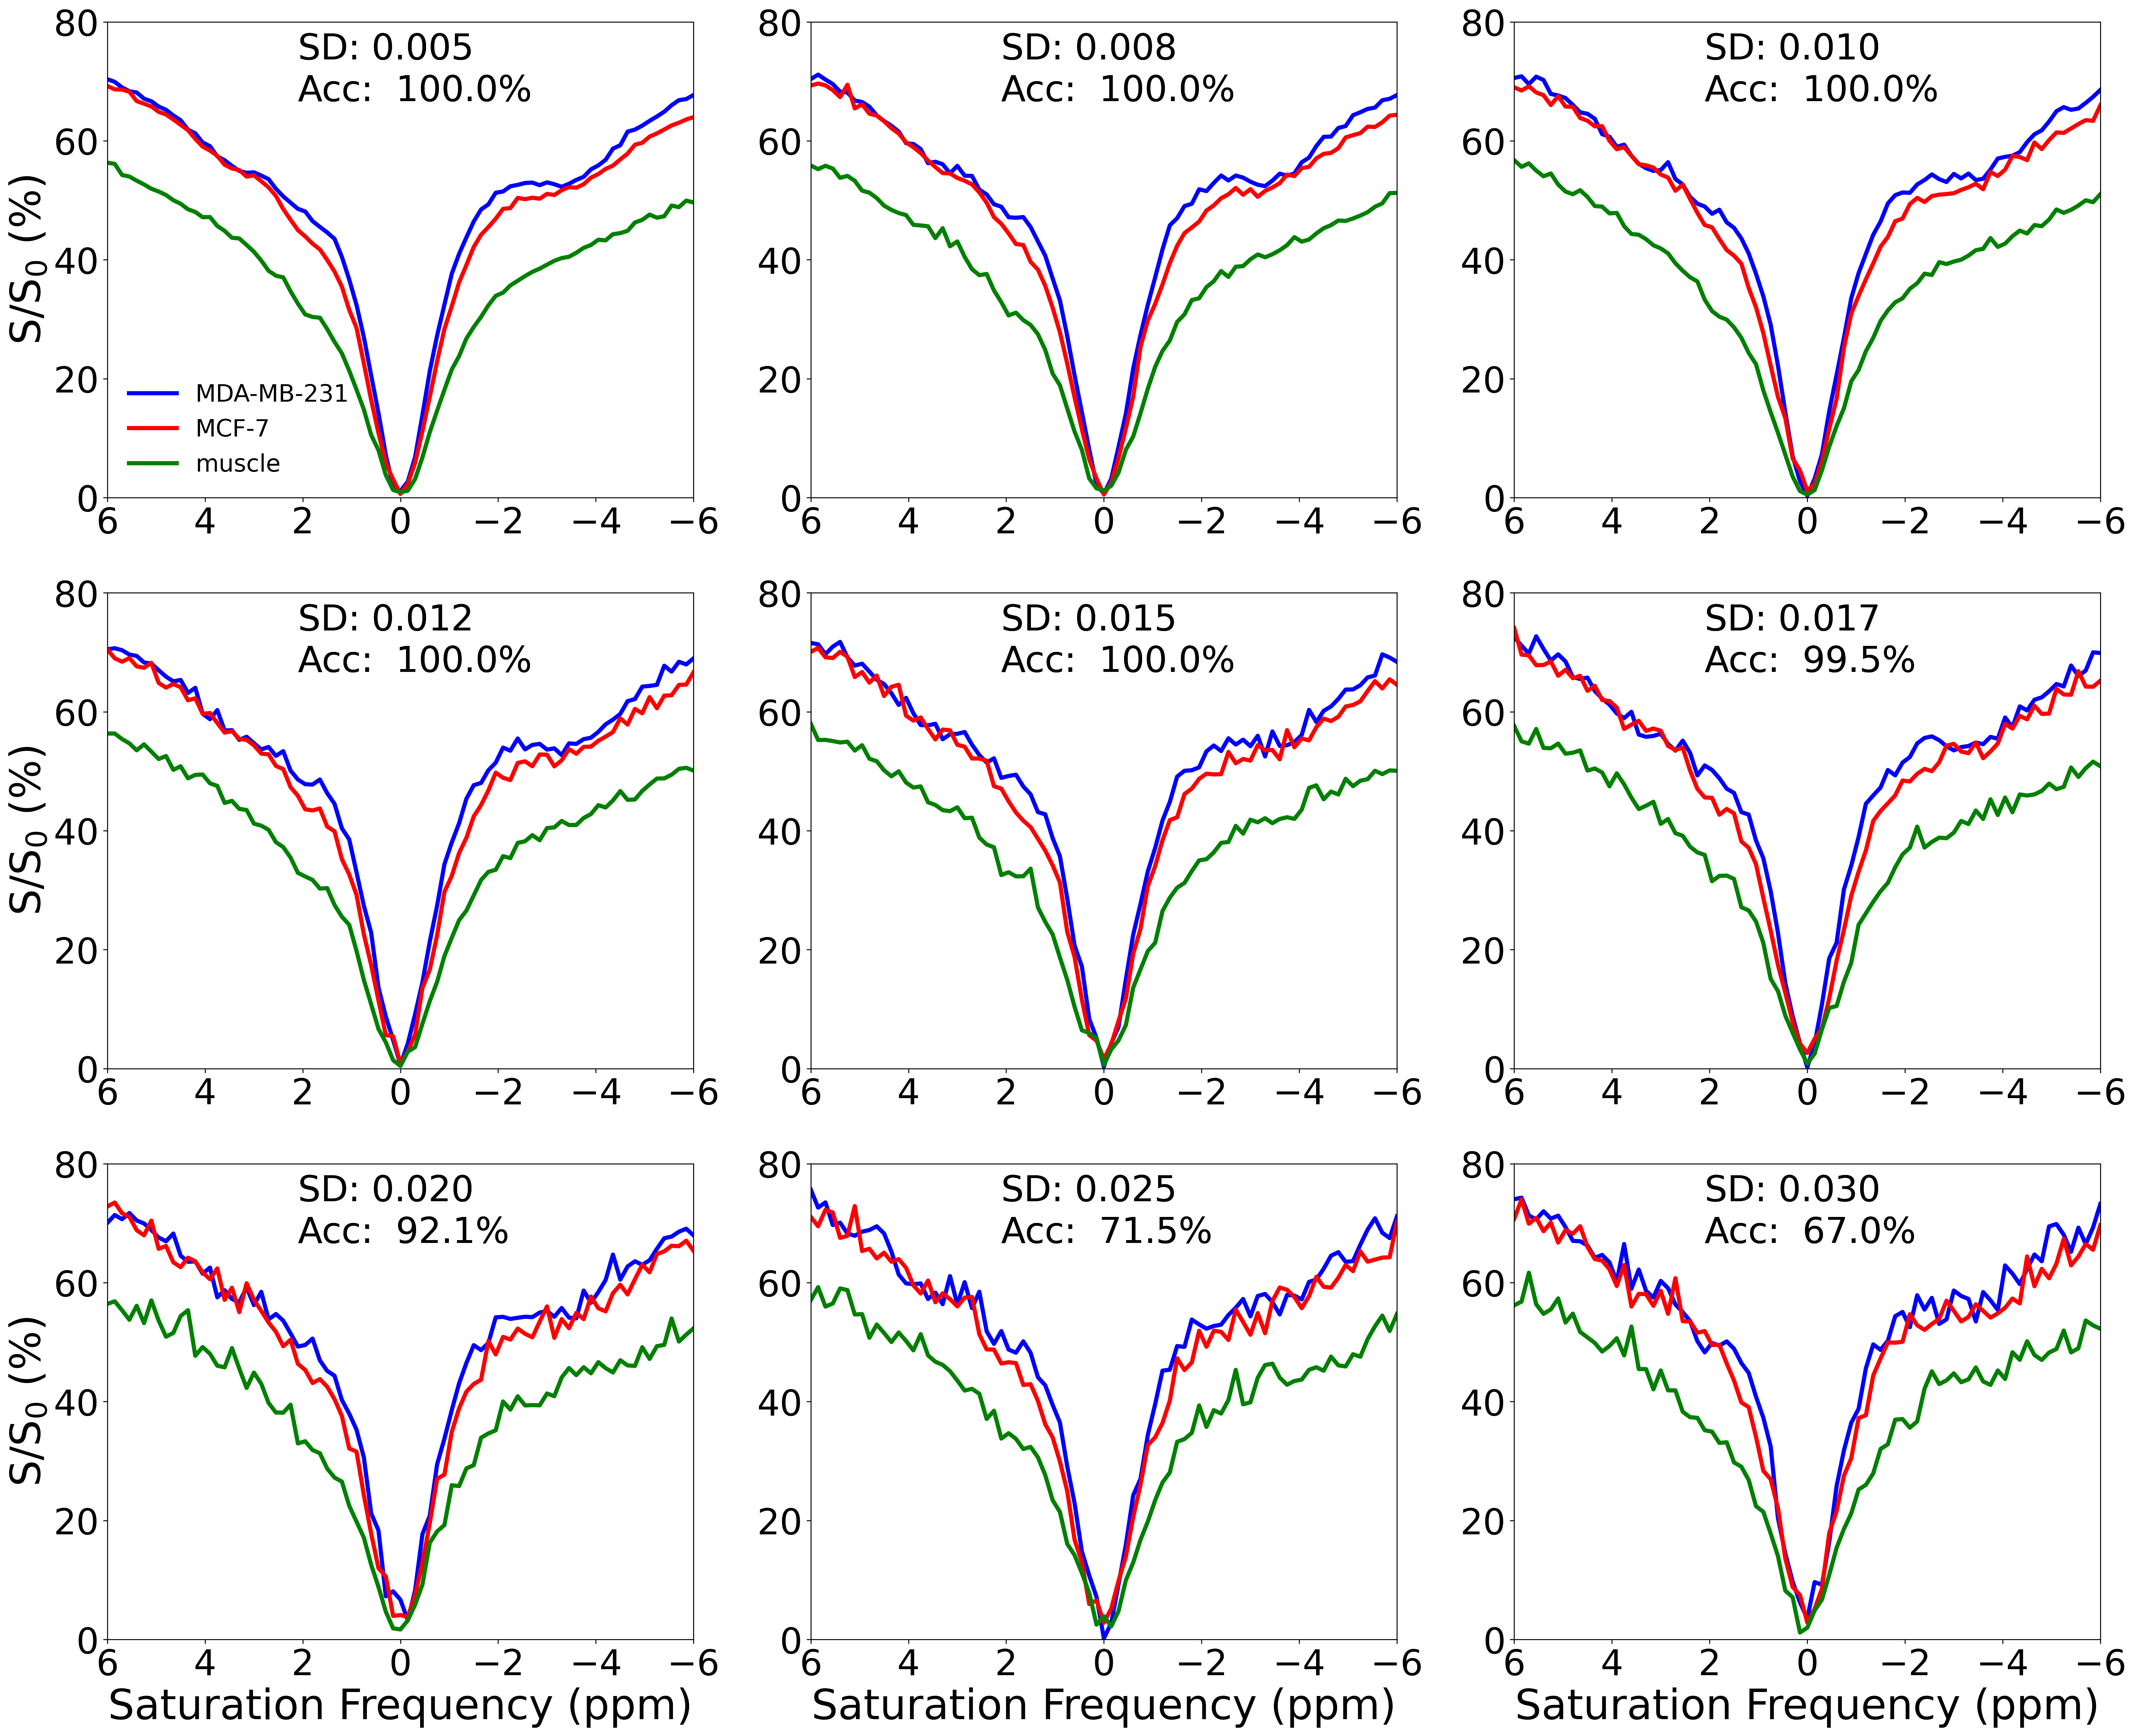

In [24]:
from matplotlib import gridspec

trainy = test_sim_index
trainX = test_sim_data_noise_use
sdNoise = r_[0.005, 0.008, 0.01, 0.012, 0.015, 0.017, 0.02, 0.025, 0.03]

dataIndexesTemp = []
for ii in range(n_classes):
    dataIndexesTemp.append(where(trainy == ii)[0][0])
dataIndexes = array(dataIndexesTemp)
dataIndexes = r_[20, 1000, 2000]

figure(figsize=(30,25),dpi=300)
# figure(dpi=300)
gs = gridspec.GridSpec(3, 3)
count = 0

for ni in range(3):
    for mi in range(3):
        
        ax = plt.subplot(gs[ni, mi])
        
        dataTemp = zeros((len(dataIndexes), trainX.shape[1]))
        print(count)
        for ii in range(len(dataIndexes)):

            dataTemp[ii] = trainX[dataIndexes[ii], :, count]*100
#             trainX[count,:,dataIndexes[ii]]
        
            

        color = ['b', 'r', 'g']
        label = ['MDA-MB-231','MCF-7','muscle']
#         legend(loc='center left',fontsize=20)
#         ax.set_title(sdNoise[count],fontsize=30)
        for ii in range(len(dataIndexes)):
            ax.plot(cestFreq, dataTemp[ii],color=color[ii],label=label[ii],linewidth=3.5)
            noise_label = sdNoise[count]
            text(2.1, 67.0,'SD: %.3f \n'%noise_label, fontsize=30, horizontalalignment='left')
            text(2.1, 60.0,'Acc:  %.1f%% \n'%Accuracy1[count], fontsize=30, horizontalalignment='left')
        ylim(0, 80)
        xlim(6, -6)
        tick_params(labelsize=30)
        xticks([6,4, 2, 0, -2, -4, -6],fontsize=30)
        
        if mi == 0:
            ylabel('S/S$_0$ (%)',fontsize=35)
        if ni == 2:
            xlabel('Saturation Frequency (ppm)',fontsize=35)
        if (mi==0)*(ni==0):  
            legend(fontsize=20, frameon=False, loc='lower left')
        count = count + 1

# xlabel('frequency (ppm)')
# ylabel('S/S$_0$ (%)')
# path = '.'
# savefig('noise_bearing_1.png', bbox_inches = "tight")

# test on in vivo data

In [324]:
# read data
import numpy

mouse = 'M3'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M1-3/'
sep_2pt = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1_3whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1_3whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1_3whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1_3whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1_3whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [344]:
mouse = 'M2'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M2/'
sep_2pt = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M2whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M2whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M2whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M2whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M2whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [380]:
mouse = 'M4'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
sep_2pt = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [57]:
import numpy
mouse = 'M5'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M4/'
sep_2pt = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

cestFreq = np.linspace(-6,6,81)

In [58]:
expDataMatrix0_2pt_use = sep_2pt
testLabel0 = Index
testLabel0 = keras.utils.to_categorical(Index, 3)

testLabel2 = Index


In [59]:
# model0 data
combinedExpData0 = []
for ii in range(expDataMatrix0_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix0_2pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_1pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_0pt5_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(lorezMatrixData0[ii,freq_Zspec0]*100)
    combinedExpData0.append(combinedExpDatai)
combinedExpData0 = array(combinedExpData0)

testInvivo0 = combinedExpData0

# testInvivo0 = data_test
testInvivo0 = reshape(testInvivo0, (testInvivo0.shape[0], testInvivo0.shape[1],1))

In [60]:
start_time = time.clock()
Invivo_pred0 = model.predict(testInvivo0,verbose=0)
# Invivo_pred0 = model.predict(testInvivo0)

Invivo_pred01 = zeros(Invivo_pred0.shape[0])

for ii in range(Invivo_pred0.shape[0]):
    Invivo_pred01[ii] = numpy.argmax(Invivo_pred0[ii])
    
print (time.clock() - start_time, "seconds")

1.6823479999999904 seconds


In [61]:
from sklearn import metrics
print('Step1: accuracy_score: %.4f' % (metrics.accuracy_score(testLabel2, Invivo_pred01)))

Step1: accuracy_score: 0.7520


In [62]:
inds_01=where((Index!=2))[0]
# print (inds_01)
print('Step1: accuracy_score: %.4f' % (metrics.accuracy_score(testLabel2[inds_01], Invivo_pred01[inds_01])))

Step1: accuracy_score: 0.7513


In [63]:
Invivo_pred = Invivo_pred01
testLabel = testLabel2

In [64]:
from imblearn.metrics import sensitivity_specificity_support
sensitivity_specificity_support(testLabel, Invivo_pred, average='macro')

(0.7445996869931961, 0.8992268021128353, None)

In [65]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(testLabel, Invivo_pred)

print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(testLabel, Invivo_pred) )
print ('Report : ')
print (classification_report(testLabel, Invivo_pred))


Confusion Matrix :
[[ 88  16   0]
 [ 31  54   0]
 [  9  70 240]]
Accuracy Score : 0.7519685039370079
Report : 
              precision    recall  f1-score   support

         0.0       0.69      0.85      0.76       104
         1.0       0.39      0.64      0.48        85
         2.0       1.00      0.75      0.86       319

    accuracy                           0.75       508
   macro avg       0.69      0.74      0.70       508
weighted avg       0.83      0.75      0.77       508



In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Pastel1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    matrix = zeros(cm.shape)
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            if ii == jj:
                matrix[ii, jj] = 0.08
            else:
                matrix[ii, jj] = 0.1

    plt.imshow(matrix, cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        tag = "{:.1f}%".format(round(cm[i, j]*100,1))
        if tag == 'nan%':
            tag = 'None'
        if i == j:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
        else:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
#         plt.text(j, i, tag, fontsize=13,
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predictive label',fontsize=20)

Normalized confusion matrix
[[0.85 0.15 0.  ]
 [0.36 0.64 0.  ]
 [0.03 0.22 0.75]]


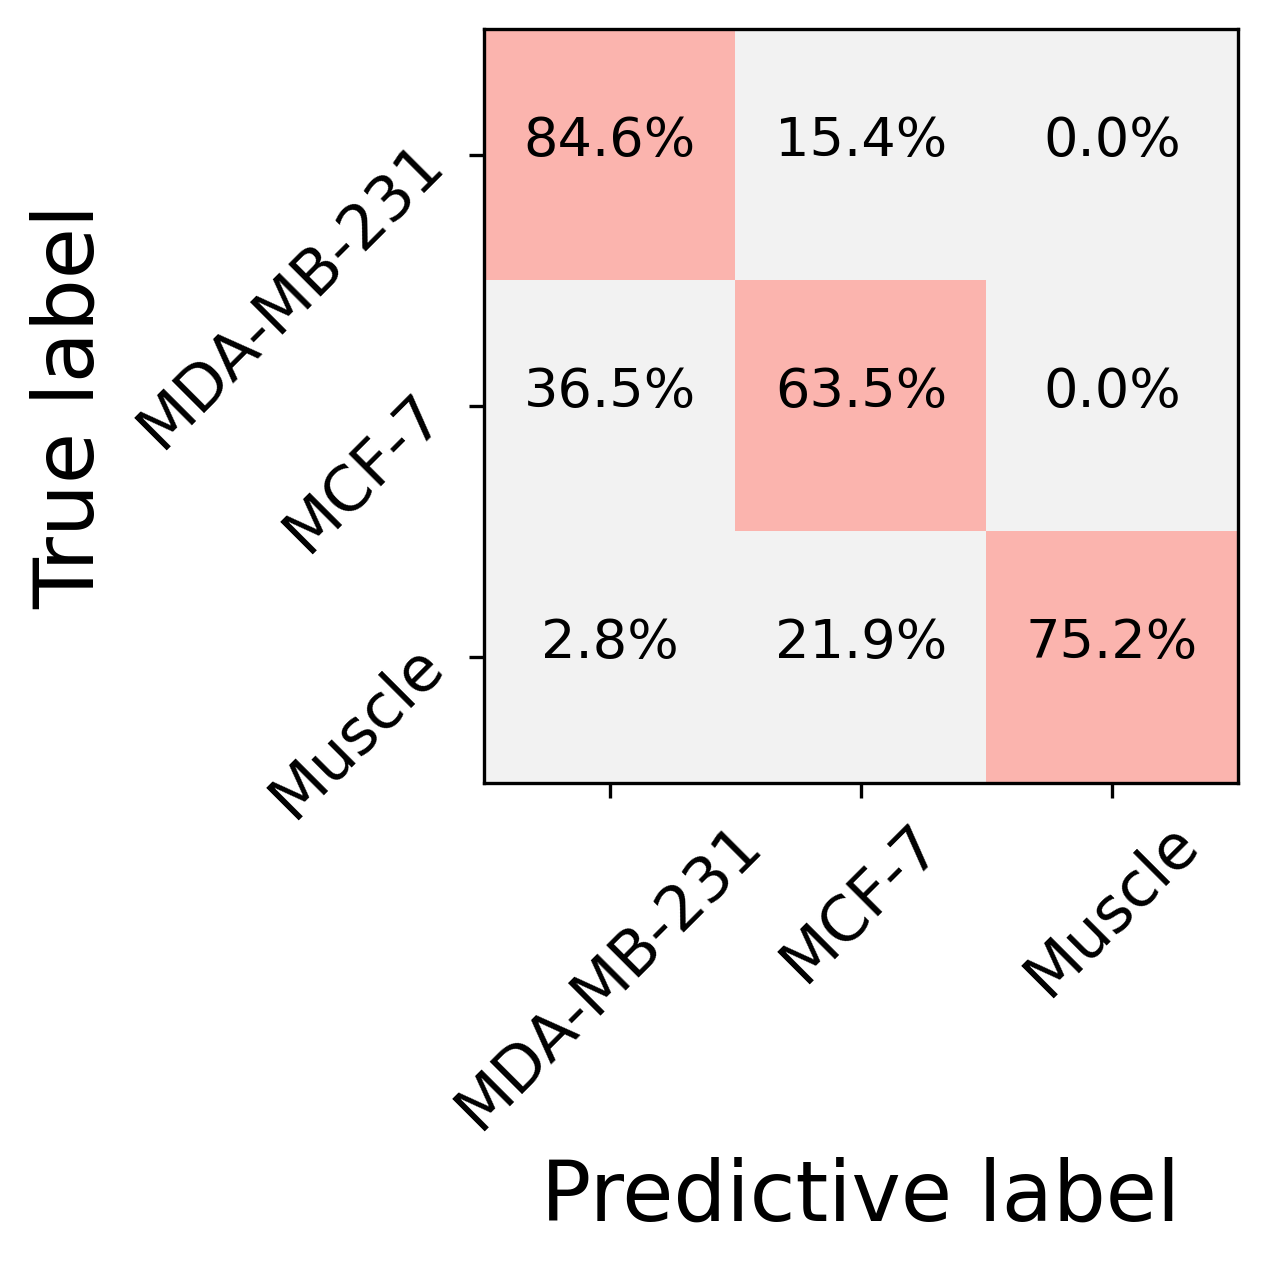

In [67]:
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['MDA-MB-231','MCF-7','Muscle']
cnf_matrix = confusion_matrix(testLabel, Invivo_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=300)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize=True)
plt.show()

In [68]:
# save predicted results
numpy.savetxt(path2 + mouse+ '_pred_sep_knn_2uT_1.csv', Invivo_pred01, delimiter = ',')


In [42]:
y_score = model.predict(testInvivo0,verbose=0)
y_test = testLabel0

y_score_new = zeros(y_score.shape)
for ii in range(y_score.shape[0]):
    for jj in range(y_score.shape[1]):
        y_score_new[ii,jj] = round(y_score[ii,jj],3)

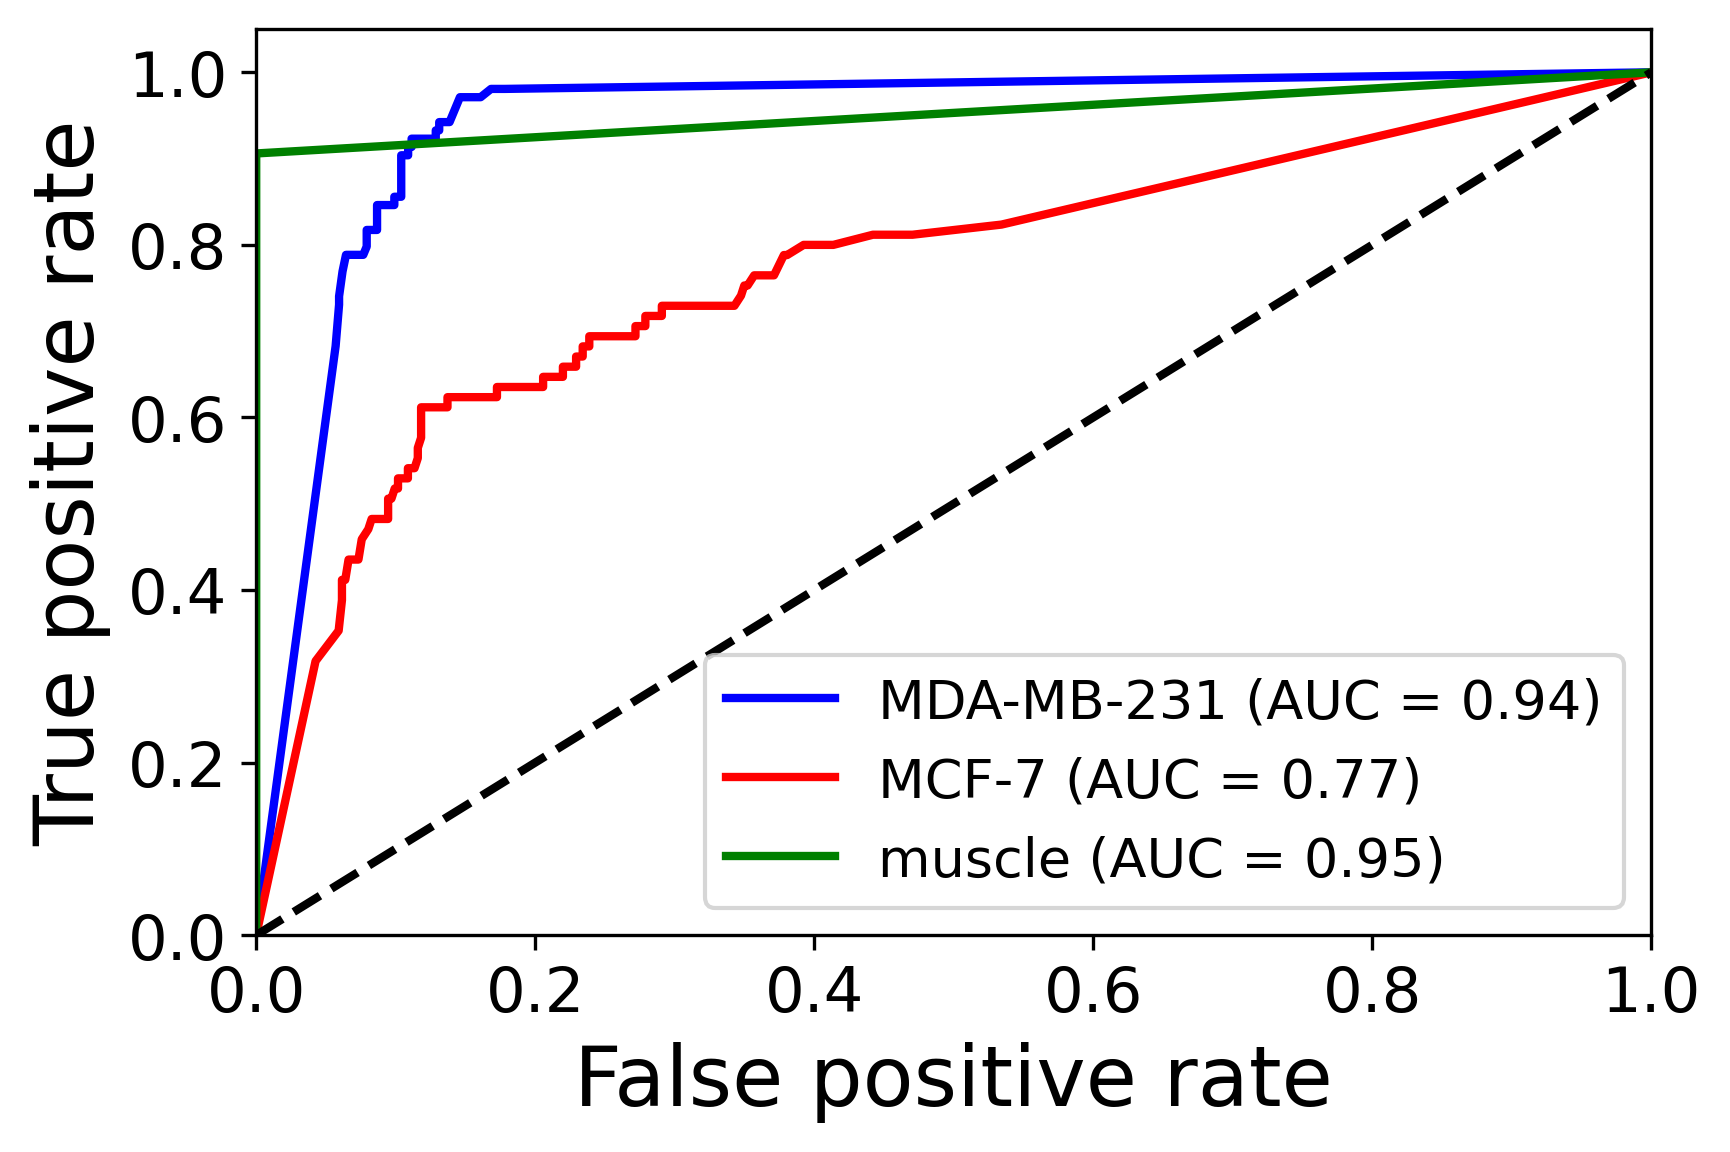

In [43]:
# y_score = model.predict_proba(testInvivo0)
# # y_score = Invivo_pred0
# y_test = testLabel0

import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_new[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
plt.figure(1, dpi=300)

colors = cycle(['b', 'r', 'g'])
class_label=['MDA-MB-231', 'MCF-7','muscle']

for i, color in zip(range(n_classes), colors):
    if pd.isnull(roc_auc[i]) == False:
        plt.plot(fpr[i], tpr[i],  color=color, lw=lw,
             label='{0} (AUC = {1:0.2f})'
             ''.format(class_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=13)
plt.tick_params(labelsize=15)
plt.show()


 